In [1]:
import matplotlib.pyplot as plt
import numpy as np
plt.rcParams["figure.dpi"] = 1200
plt.rcParams["font.family"] = "serif"

d_l = 4000  # distance of the lens in pc
d_s = 5000 # distance of the source in pc
M0 = 0.01 # mass of the main lens in units of M_sol
diameter_s = 1  # source size in units of R_sol

In [2]:
d_l = 4000  # distance of the lens in pc
d_s = 5000 # distance of the source in pc
M0 = 0.01 # mass of the main lens in units of M_sol
diameter_s = 1  # source size in units of R_sol

In [3]:
# compute lensing properties
from lenstronomy.Cosmo.micro_lensing import einstein_radius, source_size
theta_E = einstein_radius(M0, d_l, d_s)
size_s = source_size(diameter_s, d_s)

In [4]:
# compute ray-tracing grid
grid_scale = size_s / 4.  # ten times the source size resolution
grid_width = theta_E * 4
num_pix = int(grid_width / grid_scale)
from lenstronomy.Util import util
x, y = util.make_grid(numPix=num_pix, deltapix=grid_scale)

# Sidebar: Calculating Magnification

The magnification $\mu$ at a point is given by the inverse of the determinant of the lensing Jacobian, evaluated at the desired point. Indeed, $\texttt{lenstronomy}$ has a built-in method to calculate magnification in this way. Our concern, however, is with evaluating magnification "globally."

In general, to do this, we would appply the formula

$$\mu = \frac{\text{lensed integrated flux}}{\text{unlensed integrated flux}}.$$

To calculate integrated flux from an image such as we make with $\texttt{util.array2image(surface_brightness)}$, we take the product of the total surface brightness with the pixel area. 

$$\text{integrated flux} = \left(\sum \text{surface brightness}\right) \cdot (\text{pixel area})$$

(We need not multiply this by the total number of pixels, because such information is already contained in the "total" surface brightness._

In general, the pixel area element will vary depending on how we construct our ray-tracing grid. To see why this matters, one can increase the mass of the lens above (to, say, $0.05$ solar masses). Holding all else constant, this should result in more magnification. However, if one simply sums the surface brightness with the original mass, and compares that with the sum of the surface brightness with the larger mass, the result is that the summed surface brightess is greater in the former case, an apparent contradiction. The resolution to this contradiction is that the two images have different pixel area elements; once this is taken into account in the magnification cauclation, it is indeed the case that the more massive lens results in more magnification.

Fortunately, for our purposes below, we change nothing about the grid. In fact, all we vary is the source $x$ coordinate on the sky--for fixed $y$, this creates a horizontal source trajectory--and between source trajectories, we vary $y$, so that each source trajectory has a different impact parameter. In other words, all that ever changes is the position of the source star. For the values of $x$ and $y$ that we pick, the source star is always contained fully within the grid, and the grid itself never changes. The upshot is that since the pixel area-related elements are the same in numerator and denominator, we can just compute magnification by 

$$\mu = \frac{\sum \text{lensed surface brightness}}{\sum \text{unlensed surface brightness}}$$.

What's more, we only need to compute the unlensed surface brightness once; and then we can use that same value in all subsequent magnification calculations.

In [5]:
# set Einstein radius to zero - we just want to see the unlensed source for a moment
from lenstronomy.LensModel.lens_model import LensModel
lens = LensModel(lens_model_list=['POINT_MASS'])
kwargs_lens = [{'theta_E': 0, 'center_x': 0, 'center_y': 0}]
beta_x, beta_y = lens.ray_shooting(x, y, kwargs=kwargs_lens)

# compute surface brightness of the unlensed source
from lenstronomy.LightModel.light_model import LightModel
light = LightModel(light_model_list=['ELLIPSOID'])
kwargs_light = [{'amp': 1, 'radius': size_s/2 * 10, 'e1': 0, 'e2': 0, 'center_x': 0, 'center_y': 0}]

surface_brightness = light.surface_brightness(beta_x, beta_y, kwargs_light)
unlensed_total_surface_brightness = np.sum(surface_brightness) # reference value when computing magnifications

In [6]:
def plotter(impact_parameter):
    lens = LensModel(lens_model_list=['POINT_MASS'])
    kwargs_lens = [{'theta_E': theta_E, 'center_x': 0, 'center_y': 0}]
    beta_x, beta_y = lens.ray_shooting(x, y, kwargs=kwargs_lens) # map image to source plane
    light = LightModel(light_model_list=['ELLIPSOID'])
    magnifications = []
    multipliers = []
    for val in range(-1389,1381): # range that ensures the star is contained entirely within the grid
        multiplier = val / 1000
        kwargs_light = [{'amp': 1, 'radius': size_s / 2 * 10, 'e1': 0, 'e2': 0, 'center_x': multiplier * theta_E, 'center_y': impact_parameter*theta_E}]
        surface_brightness = light.surface_brightness(beta_x, beta_y, kwargs_light) # compute surface brightness
        magnification = np.sum(surface_brightness) / unlensed_total_surface_brightness
        magnifications.append(magnification)
        multipliers.append(multiplier)
    return multipliers, magnifications

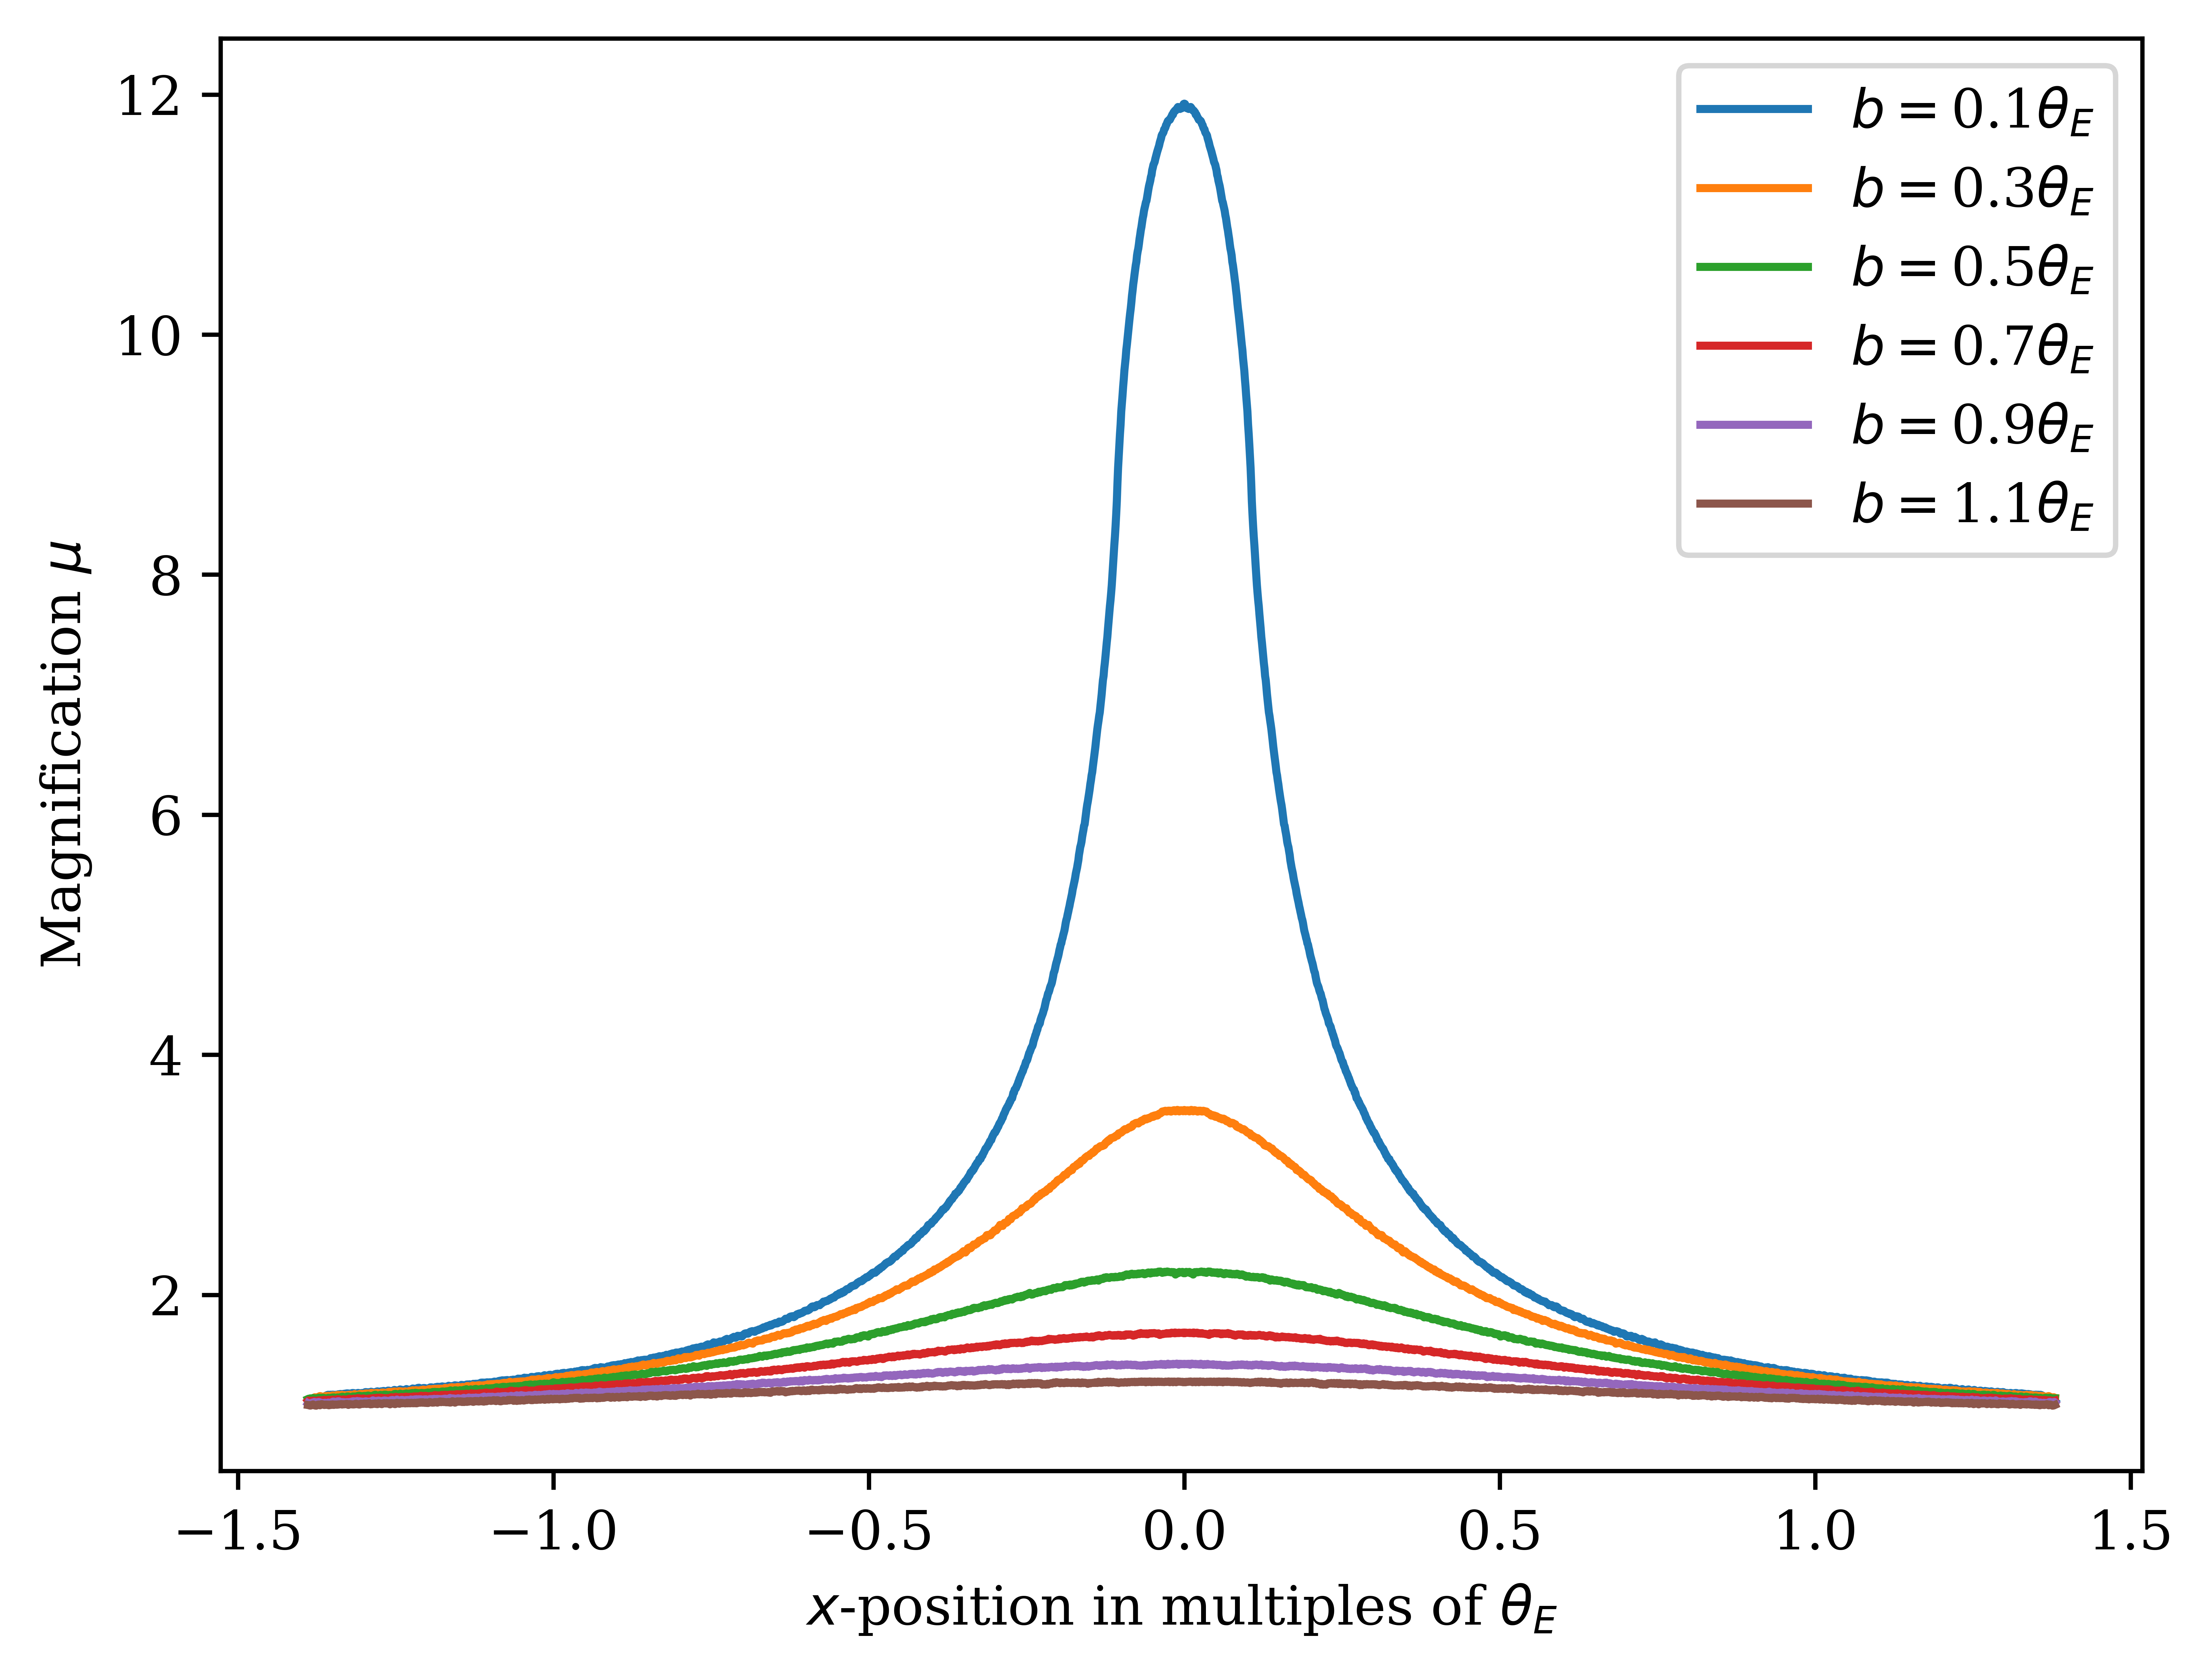

In [7]:
desired_impact_parameters = [0.1, 0.3, 0.5, 0.7, 0.9, 1.1]
for impact_parameter in desired_impact_parameters:
    plt.plot(plotter(impact_parameter)[0], plotter(impact_parameter)[1], label = '$b= $' + str(impact_parameter) + r'$\theta_{E}$')
plt.legend()
plt.xlabel("$x$-position in multiples of " r'$ \theta_{E}$')
plt.ylabel("Magnification $\mu$")
plt.show()

(Note that we could equally well call the horizontal axis of the above plot "Time" (to match exactly the form of the plot in Meneghetti), since the motion of the source is assumed to be rectilinear and so there is a perfect correspondence between position and time.)